In [188]:
from BlackJack_classes import *
import pandas as pd

card_values = ['2','3','4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
card_suits = ['Hearts', 'Diamonds', 'Spades', 'Clubs']

In [189]:
from collections import namedtuple

sa_tuple = namedtuple(typename = "state_action_tuple",
                     field_names = ('state', 'action'))

class RL_Player(Player):
    """A reinforcement learning agent that uses a policy to determine moves"""
    
    def __init__(self, name, lr):
        super().__init__()
        self.name = name
        self.lr = lr
        self.state_actions = []
        # player score: [0,31]
        # dealer score of faceup: [1,10] => Ace =1
        # has useable ace: [0, 1] if has Ace and score + 11 <= 21
        self.Q = np.random.rand(32, 10, 2, 2) # action value function
        self.pi = np.round(np.random.rand(32, 10, 2, 1), 0) # policy - last array is only action to choose (1, 0)
        
        self.useable_ace = False
        
        
    def calcScore(self):
        temp_score = 0

        # split cards for score calculation
        non_aces = [card for card in self.hand if card.value != 'A']
        aces = [card for card in self.hand if card.value == 'A']

        # check that there actually are cards
        num_non_aces = len(non_aces)
        num_aces = len(aces)

        if num_non_aces > 0:
            for card in non_aces:
                if card.value.isdigit():
                    temp_score += int(card.value)
                elif card.value in {'K', 'Q', 'J'}:
                    temp_score += 10

        if num_aces > 0:
            # checks for rare cases of multiple aces
            if temp_score + 11 + 1 * (num_aces - 1) <= 21:
                temp_score += 11 + 1 * (num_aces - 1)
                self.useable_ace = True
                
            else:
                temp_score += 1 * num_aces
                self.useable_ace = False

        self.score = temp_score

        if self.score > 21:
            self.bust = True
            
    def getDealerCardScore(self, card):
        if card.value.isdigit():
            score = int(card.value)
        elif card.value in {'K', 'Q', 'J'}:
            score = 10
        elif card.value == 'A':
            score = 1
        return score
            
        
    def hitOrStay(self, faceup):
        score_idx = self.score 
        faceup_idx = self.getDealerCardScore(faceup) - 1 # minus one for idx
        useable_ace = int(self.useable_ace) # get function to determine this
        move = self.pi[score_idx, faceup_idx, useable_ace, 0]
        
        # record your moves here for MC update function
        # state = (score_idx, faceup_idx)
        # action = move
        self.state_actions.insert(
            0, # insert state_action at first index
            sa_tuple(
                (int(score_idx), int(faceup_idx), int(useable_ace)),
                int(move)              
            )
        )
        
        # hit is 0, stay is 1
        if move == 0:
            return True
        elif move == 1:
            return False

    
    def updateWins(self, game_id, result):
        self.wins[game_id] = result
        self.updatePolicy(game_id)
        
    def updatePolicy(self, game_id):
        # most recent action at start 
        # only winning / loosing / drawing contains a score. 
        # no discounting

        for val in self.state_actions:

            action = val.action
            state = val.state

            old = self.Q[state[0], state[1], state[2], action]
            new = old + self.lr * (self.wins[game_id] - old)
            
            self.Q[state[0], state[1], state[2], action] = new

            
            self.pi[state[0], state[1], state[2], 0] = np.argmax(self.Q[state[0], state[1], state[2],])

        self.state_actions = [] # reset state actions
        self.useable_ace = False # reset useable ace

class softRL_Player(RL_Player):
    """RL player that uses a soft-epsilon policy"""
    def __init__(self, name, lr, epsilon):
        super().__init__(name, lr)
        # self.name = name
        # self.lr = lr
        self.epsilon = epsilon
        raw_pi = np.random.rand(32, 10, 2, 2)

        # ensure pi is normalised for probs
        raw_total = np.sum(raw_pi, axis = 3)
        self.pi = raw_pi / raw_total[:,:,:,np.newaxis] # policy - last array is probs for each action

    def hitOrStay(self, faceup):
        score_idx = self.score 
        faceup_idx = self.getDealerCardScore(faceup) - 1 # minus one for idx
        useable_ace = int(self.useable_ace) # get function to determine this
        probs = self.pi[score_idx, faceup_idx, useable_ace, ]
        move = np.random.choice([0,1], p = probs)
        
        # record your moves here for MC update function
        # state = (score_idx, faceup_idx)
        # action = move
        self.state_actions.insert(
            0, # insert state_action at first index
            sa_tuple(
                (int(score_idx), int(faceup_idx), int(useable_ace)),
                int(move)              
            )
        )
        
        # hit is 0, stay is 1
        if move == 0:
            return True
        elif move == 1:
            return False

    
    def updateWins(self, game_id, result):
        self.wins[game_id] = result
        self.updatePolicy(game_id)
        
    def updatePolicy(self, game_id):
        # most recent action at start 
        # only winning / loosing / drawing contains a score. 
        # no discounting

        for val in self.state_actions:

            action = val.action
            state = val.state

            old = self.Q[state[0], state[1], state[2], action]
            new = old + self.lr * (self.wins[game_id] - old)
            
            self.Q[state[0], state[1], state[2], action] = new

            a_star = np.argmax(self.Q[state[0], state[1], state[2],])
            not_a_star = np.abs(a_star - 1) # gives 1 if 0, 0 if 1
            
            self.pi[state[0], state[1], state[2], a_star] = 1 - self.epsilon + self.epsilon / 2
            self.pi[state[0], state[1], state[2], not_a_star] = self.epsilon / 2

        self.state_actions = [] # reset state actions
        self.useable_ace = False # reset useable ace


class Test_Player(Player):
    """Player with test strategies for benchmarking - random guess (50/50)
    Always Hit, Always Stay"""
    
    def __init__(self, name, strat):
        super().__init__()
        self.name = name
        self.strat = strat
        
    def HitOrStay(self):
        if self.strat == 'RANDOM':
            return True if np.random.uniform() <= 0.5 else False
        elif self.strat == 'HIT':
            return True
        elif self.strat == 'STAY':
            return False
    

In [398]:
a_deck_of_cards = [Card(value, suit) for value in card_values for suit in card_suits]

aDeck = Deck(a_deck_of_cards)

Player1 = softRL_Player(name='LR_0.001 - soft (0.01)', lr = 0.001, epsilon = 0.01)
Player2 = softRL_Player(name='LR_0.001 - soft (0.05)', lr = 0.001, epsilon = 0.05)
Player3 = softRL_Player(name='LR_0.001 - soft (0.1)', lr = 0.001, epsilon = 0.1)
Player4 = RL_Player(name = 'LR_0.001',lr = 0.001)
# Player5 = softRL_Player(name='LR_1 - soft (0.005)', lr = 1, epsilon = 0.005)
# Player1 = RL_Player(name='LR_0.001', lr = 0.001)
# Player4 = Test_Player(name = 'Random', strat = 'RANDOM') # 50 / 50 player
# # Player5 = Test_Player(name = 'Always_hit', strat = 'HIT') # always hits
# # Player6 = Test_Player(name = 'Always_stay', strat = 'STAY') # always stays
# Player7 = Dealer() # dealer strategy

Players = [
    Player1,
     Player2,
      Player3, 
      Player4,
    #   Player5
      ]


aDealer = Dealer()



In [399]:
for i in range(1,5000000):
    for aPlayer in Players:
        aGame = Game(i,aDeck, [aPlayer], aDealer, VERBOSE = False)
        aGame.play()


In [400]:
all_results = pd.DataFrame()
for aPlayer in Players:
    results_df = pd.DataFrame(pd.Series(aPlayer.wins))
    results_df.rename({0:'result'}, axis =1, inplace = True)
    results_df['win'] = results_df.result > 0
    results_df['n'] = results_df.index
    # results_df = results_df[results_df.n > 40000]
    results_df['win_rate'] = round(100*results_df.win.cumsum()/(results_df['n'] ),2)
    results_df['name'] = aPlayer.name
    all_results = pd.concat([all_results, results_df])
    
all_results.reset_index(inplace = True)

Text(32.417265625000006, 0.5, 'Win Rate')

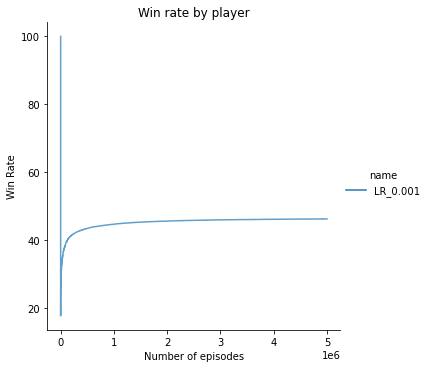

In [401]:
import seaborn as sns
import matplotlib.pyplot as plt

wide_results = pd.pivot_table(all_results, index = 'n', columns = 'name', values = 'win_rate')

sns.relplot(data = wide_results, alpha = 0.7, kind= 'line');
plt.title('Win rate by player')
plt.xlabel('Number of episodes')
plt.ylabel('Win Rate')


In [402]:
all_results[['win_rate', 'name']].groupby('name').mean().sort_values(by = 'win_rate', ascending = False)

,win_rate
name,
LR_0.001,45.113956


In [403]:
last_results = all_results[all_results.n > 49000].copy()
last_results.groupby('name').sum() / 1000 # gives approx win-rate over the last 10000

# first_results = all_results[all_results.n < 1000].copy()
# first_results.groupby('name').sum() / 1000

,index,result,win,n,win_rate
name,,,,,
LR_0.001,1.249880e+10,-365.355,2292.822,1.249880e+10,223977.67343


C:\Users\61417\AppData\Local\Temp/ipykernel_13240/3695752951.py:54: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf)


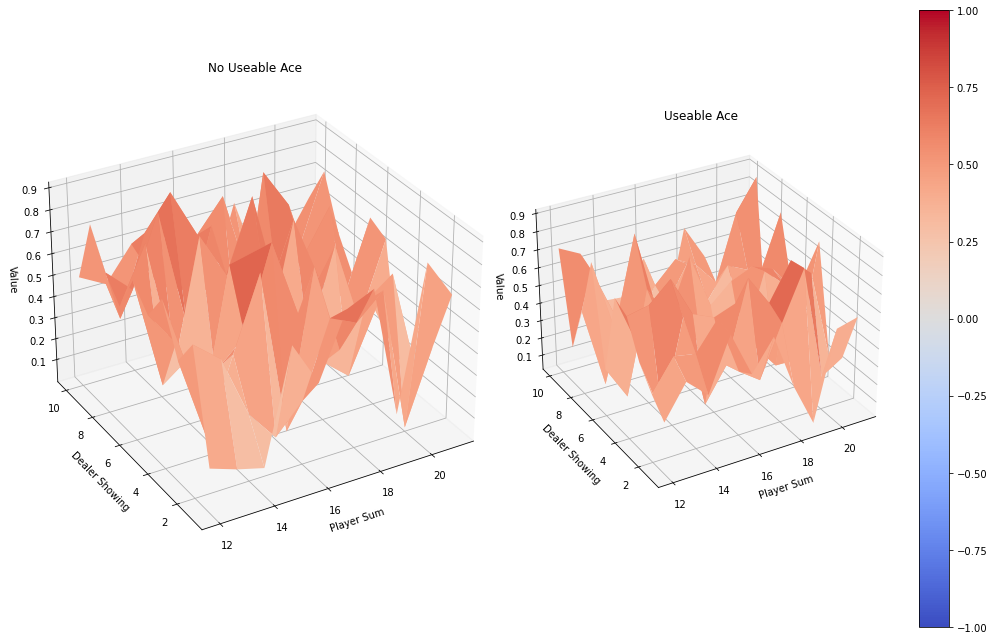

In [456]:

def plotValueFunction(aPlayer):

    # calculate value func
    value_func = np.sum(aPlayer.Q * aPlayer.pi, axis = 3) 

    # get X, Y for restricted axis - 12 to 21, dealer showing 0 - 10 
    X, Y = np.meshgrid(np.array([i for i in range(12, 22)]), [j for j in range(0, 10)])

    Z_noace = np.apply_along_axis(lambda _: value_func[(_[0], _[1], 0)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: value_func[(_[0], _[1], 1)], 2, np.dstack([X, Y]))

    # Creating figure
    # fig, _ = plt.subplots(1,2,2, figsize=(14,9))
    fig = plt.figure(figsize =(14, 9))
    ax1 = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122,projection='3d')
    #ax = plt.axes(projection ='3d')
    
    # Creating plot
    # no useable ace

    surf = ax1.plot_surface(
        X, 
        Y + 1,
        Z_noace,
        rstride=1,
        cstride=1,
        cmap='coolwarm',
        vmin=-1.0,
        vmax=1.0) 

    ax1.set_xlabel('Player Sum')
    ax1.set_ylabel('Dealer Showing')
    ax1.set_zlabel('Value')
    ax1.set_title('No Useable Ace')
    ax1.view_init(ax1.elev, -120)

    surf2 = ax2.plot_surface(
        X, 
        Y + 1,
        Z_ace,
        rstride=1,
        cstride=1,
        cmap='coolwarm',
        vmin=-1.0,
        vmax=1.0) 

    ax2.set_xlabel('Player Sum')
    ax2.set_ylabel('Dealer Showing')
    ax2.set_zlabel('Value')
    ax2.set_title('Useable Ace')
    ax2.view_init(ax2.elev, -120)

    fig.colorbar(surf)
    fig.tight_layout()

    # show plot
    plt.show()




plotValueFunction(Player5)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,20))

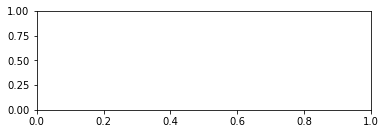

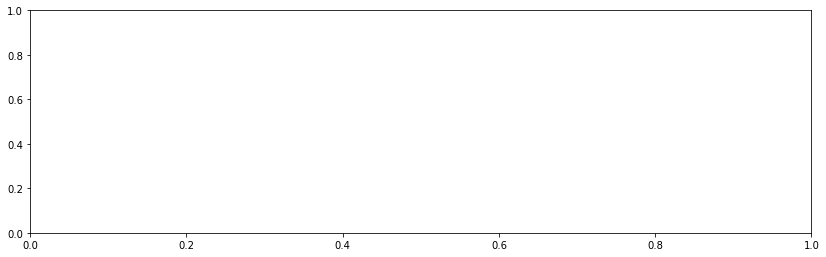

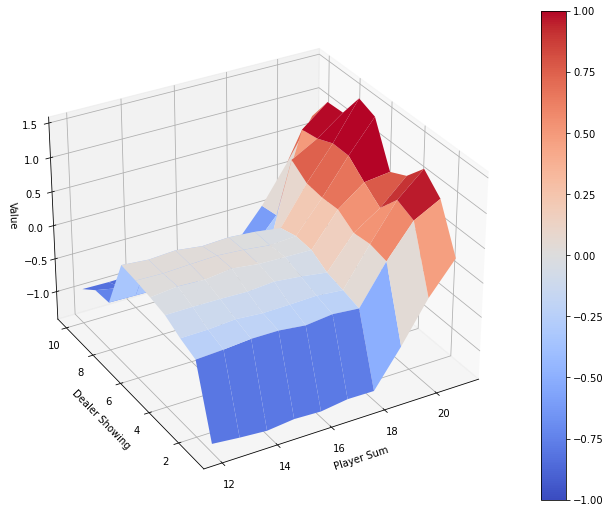

In [445]:

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(2, 1, 1)
plotValueFunction(Player4)
# plt.plot(x1, y1, 'ko-')
# plt.title('A tale of 2 subplots')
# plt.ylabel('Damped oscillation')


plt.subplot(2, 1, 2)
plotValueFunction(Player4)
# plt.plot(x2, y2, 'r.-')
# plt.xlabel('time (s)')
# plt.ylabel('Undamped')

plt.show()

In [418]:
Z_ace = np.apply_along_axis(lambda _: val[(_[0], _[1], 1)], 2, np.dstack([X, Y]))
Z_ace.shape

(10, 10)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

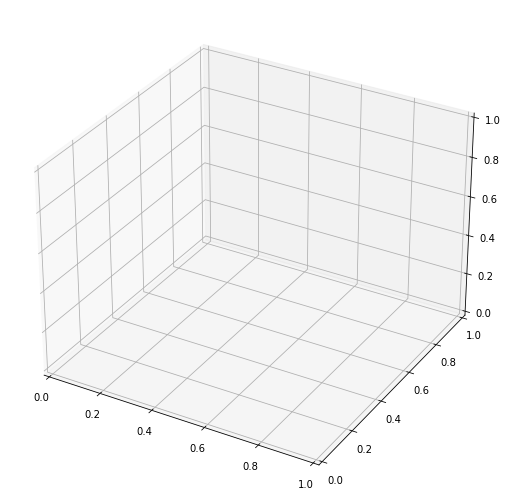

In [216]:


x = np.array([i for i in range(1, 11)])
y = np.array([i for i in range(12, 21)])
z = np.array([[i + j] for i in x for j in y])
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x, y, z)
 
# show plot
plt.show()

In [72]:
# first index is player score - ranges from 5 to 21 (17): to update value, correct index is gotten using player.score - 5
# second index is face up value of dealer - any card value (13): correct index is gotten card_value.index(card value)
# third index is actions - hit or stay (2) - arbitrarily assign hit to index 0, stay to index 1
Q = np.zeros((17, 13, 2))
pi = np.random.uniform(0,1, (17,13,2))

In [9]:


test = namedtuple(typename = 'test',
                  field_names = ('hello', "goodbye"))
test(1,2)


test(hello=1, goodbye=2)

In [67]:
from sklearn.preprocessing import normalize
new_pi = np.vstack([normalize(pi[i,], axis = 1, norm = 'l1') for i in range(0,pi.shape[0])])
print(new_pi[1,1,], pi[1,1,])

0.6308996471179777 [0.28878127 0.71379169]


In [69]:
pi[1,]

array([0.32660253, 0.07878575])

In [136]:
all_aces = [Card('A', 'Spades'), Card('10', 'Hearts'), Card('3', 'Spades'), Card('3', 'Hearts')]
aplayer = Player()
aplayer.getHand(all_aces)
aplayer.calcScore()
print(aplayer.score, aplayer.bust)

17 False


In [88]:
print(aplayer.hand)

None


In [39]:
for i in range(0, 26):
    print(i)
    k = aDeck.deal(2)
    print(aDeck[0:3], k)

0
[5 of Spades, 5 of Diamonds, 8 of Hearts] [5 of Hearts, 5 of Clubs]
1
[8 of Hearts, 8 of Clubs, 8 of Spades] [5 of Spades, 5 of Diamonds]
2
[8 of Spades, 8 of Diamonds, 3 of Hearts] [8 of Hearts, 8 of Clubs]
3
[3 of Hearts, 3 of Clubs, 3 of Spades] [8 of Spades, 8 of Diamonds]
4
[3 of Spades, 3 of Diamonds, Q of Hearts] [3 of Hearts, 3 of Clubs]
5
[Q of Hearts, Q of Clubs, Q of Spades] [3 of Spades, 3 of Diamonds]
6
[Q of Spades, Q of Diamonds, 6 of Hearts] [Q of Hearts, Q of Clubs]
7
[6 of Hearts, 6 of Clubs, 6 of Spades] [Q of Spades, Q of Diamonds]
8
[6 of Spades, 6 of Diamonds, 7 of Hearts] [6 of Hearts, 6 of Clubs]
9
[7 of Hearts, 7 of Clubs, 7 of Spades] [6 of Spades, 6 of Diamonds]
10
[7 of Spades, 7 of Diamonds, 9 of Hearts] [7 of Hearts, 7 of Clubs]
11
[9 of Hearts, 9 of Clubs, 9 of Spades] [7 of Spades, 7 of Diamonds]
12
[9 of Spades, 9 of Diamonds, A of Hearts] [9 of Hearts, 9 of Clubs]
13
[A of Hearts, A of Clubs, A of Spades] [9 of Spades, 9 of Diamonds]
14
[A of Spades,

In [37]:
aDeck.reclaimCards()

In [38]:
aDeck[0:3]

[5 of Hearts, 5 of Clubs, 5 of Spades]